# Reproducing from scratch using colorectal miRNA data

Because we did not manage to reproduce Table 2 using the code of the authors, we were wondering if it was possible if we built the network ourselves.

Because of the limited time we had left, we kept it really to the basics. 
We tried building the network for miRNA data and for gene expression data, both without multimodal dropout. For the gene expression data we encountered troubles with the RAM memory (25 GB) when splitting the data into train and test set. 
This is why we only finished the simple network for miRNA data, of which the data is way smaller.



---





**Importing required modules**

The following section shows mounting to google drive and importing the required modules. These modules can be found on our GitHub page. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from itertools import *

import numpy as np
import pandas as pd
import json
import csv
import pickle
import gzip

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

!pip install lifelines
from lifelines import utils

%cd 'drive/My Drive/Reproducibility_Project/MultimodalPrognosis-master/'

sys.path.append('/content/drive/My Drive/Reproducibility_Project/MultimodalPrognosis-master/')
from one_hot_encoding_clinical_dataset import *
from modules import Highway

**Loading the data**

Although we did not use clinical data here as a modality to train, we do needed to import it for our target values: vital status and days to death.

Furthermore, we loaded the miRNA dataset. Here we only loaded the miRNA data of the colorectal cancer types READ and COAD, because of limited time. The model is easy to extend and to use for all cancer types to train on.


In [0]:
## Load data
cancer_data = pd.read_csv('data/pancancer_biospecimen (1).csv', sep='\t', index_col=False) 
cases = []
cancer_types = []
for row in cancer_data['barcode']:
  case = row.split('-')[0:3]
  case = "-".join(case)
  cases.append(case)
for row in cancer_data['project']:
  cancer_type = row.split('-')[1]
  cancer_types.append(cancer_type)

with open('data/original_clinical_dataset.json') as f:
  clinical = json.load(f)

clinical_data = np.empty((len(clinical),43),).astype(float)
ID_ref = np.empty(len(clinical)).astype(object)
vital_status = np.empty((len(clinical),1))
days_to_death = np.empty((len(clinical),1))
j=0
for line in clinical:
  err = 0
  if 'diagnoses' in line:
    ID = line['diagnoses'][0]['submitter_id'].split("_")[0]
    ID_ref[j] = ID
    try:
      index = cases.index(ID)
    except ValueError: ## Some patients were not present in biospecimen file. This surpresses error message 
      err = 1
      
    if err == 1:
      clinical_data[j] = np.concatenate((np.array([None]),np.array([None]),np.zeros(5),np.zeros(36)),axis=0)
    else:
      disease = cancer_types[index]
      keys = ['gender','age_at_index','race']
      if not all(key in line['demographic'] for key in keys): clinical_data[j] = np.concatenate((np.array([None]),np.array([None]),np.zeros(5),np.zeros(36)),axis=0)
      clinical_data[j] = np.concatenate((encoding_gender(line['demographic']['gender']),np.array([line['demographic']['age_at_index']]),encoding_race(line['demographic']['race']),encoding_cancer_type(disease)),axis=0)
      vital_status[j] = encoding_vital_status(line['demographic']['vital_status'])
      if 'days_to_death' in line['demographic']:
        days_to_death[j] = line['demographic']['days_to_death']
      else:
        days_to_death[j] = 20000    

  else:
    clinical_data[j] = np.concatenate((np.array([None]),np.array([None]),np.zeros(5),np.zeros(36)),axis=0)
  j+=1

with gzip.open('data/output/miRNA/colorectal_READ_miRNA_data.pkl','rb') as f:
        miRNA_out = pickle.load(f)

miRNA_data = np.zeros((len(clinical),1881))
for line in list(miRNA_out.index.values):
  ID = "-".join(line.split('-')[0:3])
  indx = np.where(ID_ref == ID)
  miRNA_data[indx] = miRNA_out.loc[line] 

with gzip.open('data/output/miRNA/colorectal_COAD_miRNA_data.pkl','rb') as f:
        miRNA_out = pickle.load(f)

for line in list(miRNA_out.index.values):
  ID = "-".join(line.split('-')[0:3])
  indx = np.where(ID_ref == ID)
  miRNA_data[indx] = miRNA_out.loc[line] 

nonzero_values = ~np.all(miRNA_data == 0, axis=1)
miRNA_data = miRNA_data[nonzero_values]

vital_status = vital_status[nonzero_values]
vital_status = torch.tensor(vital_status).long()

days_to_death = days_to_death[nonzero_values]
days_to_death = torch.tensor(days_to_death).float()

**Preprocessing and splitting in train and test set**

Before entering the data into the network for training, the data is preprocessed with feature-level mean centering and the use of a logarithm. Then we made a tensor out if the data, to make it suitable for training in the neural network.

After this step we split the data in train and test set in ratio 85/15 as mentioned in the paper. Stratifying per cancer type is not needed here, because we only work with miRNA data of colorectal cancer. This is something that should be added if more cancer types are used for training the model.

In [0]:
## Preprocessing 
miRNA_data = miRNA_data.astype(float)
scaler = StandardScaler()
scaler.fit(miRNA_data)
miRNA_data = scaler.transform(np.log(miRNA_data+1)) 
miRNA_data = torch.tensor(miRNA_data).float()

## Split data in train and test set
miRNA_train, miRNA_test, vital_status_train, vital_status_test = train_test_split(miRNA_data, vital_status, test_size = 0.15)
days_to_death_train, days_to_death_test = train_test_split(days_to_death, test_size = 0.15)


**The Network**

The network is built using the following architecture mentioned in the paper:

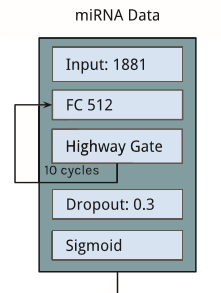

There are two outcomes. The first one is presented as a score, which consists of two values. These are the predictions for a patient of being either dead or alive.
In the loss function, this score is compared to the vital status using the PyTorch inbuilt negative log likelihood loss.
Because of limited time we did not manage to adjust the loss function so that it matches the Cox Loss mentioned in the paper. 

The second outcome is the hazard, which is a single value that corresponds to the probability of a patient passing away during any given time point. This value is used in the concordance score when testing the network on the test set. 

In [0]:
## Network

class Net(nn.Module):

    def __init__(self):
      super(Net, self).__init__()
      
      self.fcg = nn.Linear(1881,512) 
      self.highway = Highway(512,10, f=F.relu)
      self.fc2 = nn.Linear(512,2)
      self.fcd = nn.Linear(512,1)

    def forward(self, data):

        x = data
        x = self.fcg(x)
        x = self.highway(x)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(x)

        score = F.softmax(self.fc2(x.reshape(1,-1)))
        hazard = self.fcd(x.reshape(1,-1))

        return score, hazard

    def loss(self, score, hazard, vital_status):
        
        loss = F.nll_loss(score, vital_status)

        return loss 



**Training the network**

We train the network for five epochs using Adam as optimizer with a learning rate of 8e-4.

We encountered problems when the vital status was "Not Reported" in the clinical dataset. What we first did was to assign value 'None' to this, but this did not seem to work. Therefore we made an if-statement to require the vital status to be either one or zero. 

In [0]:
## Train Network
net = Net()

optimizer = optim.Adam(net.parameters(), lr=8e-4) #There was nothing mentioned in the paper about what optimizer and what learning rate to use, but we found this in the author's code.

for epoch in range(0, 5):  # loop over the dataset multiple times
    print(epoch)
    for i, data in enumerate(miRNA_train, 0):
        inputs = data
        optimizer.zero_grad()

        # forward + backward + optimize
        score, hazard = net.forward(inputs)

        # We encounterd troubles when vital_status was "Not Reported" (i.e. value None), so we implemented this if-statement to prevent this. 
        if vital_status_train[i] < 0:
          vital_status_train[i] = 0
        elif vital_status_train[i] > 1:
          vital_status_train[i] = 1
        else:
          vital_status_train[i] = vital_status_train[i]
        
        loss = net.loss(score, hazard, vital_status_train[i])
        loss.backward()
        optimizer.step()

print('Finished Training')

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
Finished Training


In [0]:
#Save network

torch.save(net, "Results/predict_miRNA_final.pth")

**Testing the network**

After training, the network was saved and it could be tested with the test data set we already constructed. We tested for 5 epochs and took the average over 5 epochs as final performance measures.

We constructed two outcome measures: accuracy and concordance score.


In [0]:
## Test Network
net = torch.load("Results/predict_miRNA_final.pth")

accuracy = np.zeros(5)
cscore = np.zeros(5)

for epoch in range(0,5):
  print(epoch)
  counts = 0
  hazard = np.zeros(len(days_to_death_test))
  
  for i, data in enumerate(miRNA_test, 0):
    inputs = data
    
    score, hazard_value = net.forward(inputs)
    hazard_value = hazard_value.detach().numpy()
    hazard[i] = hazard_value
    
    values, pred = torch.max(score, 1)
    
    # We encounterd troubles when vital_status was "Not Reported" (i.e. value None), so we implemented this if-statement to prevent this. 
    if vital_status_test[i] < 0:
      vital_status_test[i] = 0
    elif vital_status_test[i] > 1:
      vital_status_test[i] = 1
    else:
      vital_status_test[i] = vital_status_test[i]
      
    if pred == vital_status_test[i]:
      counts += 1
  
  accuracy[epoch] = counts / len(miRNA_test) * 100
  days_to_death_test_array = days_to_death_test.detach().numpy()
  days_to_death_test_array = days_to_death_test_array[:, 0]
  vital_status_test_array = vital_status_test.detach().numpy()
  vital_status_test_array = vital_status_test_array[:, 0]
  cscore[epoch] = utils.concordance_index(days_to_death_test_array, -hazard, np.logical_not(vital_status_test_array))

#Accuracy
accuracy = np.mean(accuracy)
print("Accuracy", accuracy)

#C-score
cscore = np.mean(cscore)
print("Concordance score", cscore)


0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
Accuracy 71.7948717948718
Concordance score 0.5226666666666666


**Results**

After five epochs we ended up with an accuracy of 71.8% and a concordance score of 0.52.